In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
import warnings
import os
from econml.dml import LinearDML
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from catboost import CatBoostClassifier, Pool, cv
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

### Load data

In [2]:
path = 'https://raw.githubusercontent.com/McGill-MMA-EnterpriseAnalytics/customer_banking/uplifting_model/Dataset/bank-full.csv'
dataset = pd.read_csv(path,sep = ';')
dataset

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [3]:
dataset['poutcome'].value_counts()

poutcome
unknown    36959
failure     4901
other       1840
success     1511
Name: count, dtype: int64

In [4]:
dataset['y'] = dataset['y'].map({'yes': 1, 'no': 0})
dataset

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,1
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,1
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,1
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,0


In [5]:
# preprocessing

# 30% of the data in 'contact' is unknown, so we will drop this column
dataset = dataset.drop(['contact'], axis=1)

# managing categorical variables
# convert binary variables to 0 and 1
dataset['default'] = dataset['default'].map({'yes': 1, 'no': 0}).astype(int)
dataset['housing'] = dataset['housing'].map({'yes': 1, 'no': 0}).astype(int)
dataset['loan'] = dataset['loan'].map({'yes': 1, 'no': 0}).astype(int)


### Causal Inference

Does a successful outcome in a previous marketing campaign increase the likelihood of a client subscribing to a term deposit in the current campaign?
*   Target: being subscription (yes or no)
*   Treatment group: having had a successful previous campaign outcome (success)
*   Control group: having had any other outcome (failure and other)

In [6]:
# convert 'poutcome' to a binary treatment variable
dataset['T'] = dataset['poutcome'].apply(lambda x: 1 if x == 'success' else 0)

In [7]:
VARS = [
    'age',
    'job',
    'marital',
    'education',
    'balance',
    'housing',
    'loan',
    #'contact',
    'day',
    'month',
    'duration',
    'campaign',
    'pdays',
    'previous'
    ]
CAT_VARS = [
    'job',
    'marital',
    'education',
    'housing',
    'loan',
    #'contact',
    'month'
    ]

In [8]:
# encode categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), CAT_VARS)
    ],
    remainder='passthrough'
)


In [9]:
# selecting variables
X = preprocessor.fit_transform(dataset[VARS])
X = pd.DataFrame(X, columns=preprocessor.get_feature_names_out())

# treatment and outcome
T = dataset['T']
y = dataset['y']

# I assume all variables except treatment can act as confounders for simplicity
W = X.copy()

### Approach 1: LinearDMLCateEstimator

In [10]:
from econml.dml import DML
from econml._cate_estimator import BaseCateEstimator
from econml._cate_estimator import LinearCateEstimator
from econml._cate_estimator import *
from econml.dml import *
from econml.dml import LinearDML
from econml.dml import LinearDML, CausalForestDML
import scipy.special

# for reproducibility
np.random.seed(123)

In [11]:
from sklearn.linear_model import LassoCV

# LinearDML estimator with LassoCV models for the outcome and treatment
linear_dml_est = LinearDML(
    model_y=LassoCV(),
    model_t=LassoCV(),
    discrete_treatment=True,  # since T is binary
    random_state=123
)


In [12]:
# fit the estimator - with W as confounders (all variables except treatment)
linear_dml_est.fit(y, T, X=None, W=X)  #  we use W=X assuming all other variables can act as confounders

# for effect estimation I do not pass X since it was not used during fitting
linear_dml_ate = linear_dml_est.effect()
linear_dml_ci_lower, linear_dml_ci_upper = linear_dml_est.effect_interval(alpha=0.05)


In [13]:
print("LinearDML Average Treatment Effect:", linear_dml_ate)
print("Confidence Interval:", linear_dml_ci_lower, linear_dml_ci_upper)

LinearDML Average Treatment Effect: [0.49955381]
Confidence Interval: [0.47535169] [0.52375593]


#### Interpreting the effects from LinearDML as importance

In [17]:
# plotting the Average Treatment Effect (ATE) and its Confidence Interval
ate = linear_dml_est.effect()
ate_ci_lower, ate_ci_upper = linear_dml_est.effect_interval()

print(f"Average Treatment Effect (ATE): {ate}")
print(f"ATE 95% Confidence Interval: [{ate_ci_lower}, {ate_ci_upper}]")


Average Treatment Effect (ATE): [0.49955381]
ATE 95% Confidence Interval: [[0.47535169], [0.52375593]]


### Approach 2: CausalForestDML

In [31]:
from econml.dml import CausalForestDML
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression

In [32]:
# CausalForestDML estimator
causal_forest_dml_est = CausalForestDML(
    model_y=GradientBoostingRegressor(),  # model for the outcome
    model_t=LogisticRegression(),  # model for the treatment
    discrete_treatment=True,  # T is binary
    n_estimators=100,  # number of trees in the forest
    min_samples_leaf=5,  # minimum number of samples in a leaf
    max_depth=None,  # maximum depth of the trees
    inference=True,  # enable inference for confidence intervals
    random_state=123  # for reproducibility
)

In [33]:
# fitting the estimator with the dataset
causal_forest_dml_est.fit(y, T, X=X, W=None)  # no need to specify W since X is being used


In [34]:
# estimating the average treatment effect (ATE) on the treated
causal_forest_ate = causal_forest_dml_est.ate(X)


In [35]:
# estimating the confidence interval for the ATE
causal_forest_ci_lower, causal_forest_ci_upper = causal_forest_dml_est.ate_interval(X, alpha=0.05)


In [36]:
print("CausalForestDML Average Treatment Effect:", causal_forest_ate)
print("Confidence Interval:", causal_forest_ci_lower, causal_forest_ci_upper)

CausalForestDML Average Treatment Effect: 0.19190559016696324
Confidence Interval: -0.7618559703725973 1.1456671507065237


#### CausalForestDML SHAP Values

In [51]:
import shap

# compute SHAP values - this takes some time 
shap_values = causal_forest_dml_est.shap_values(X)

100%|===================| 45166/45211 [16:06<00:00]        

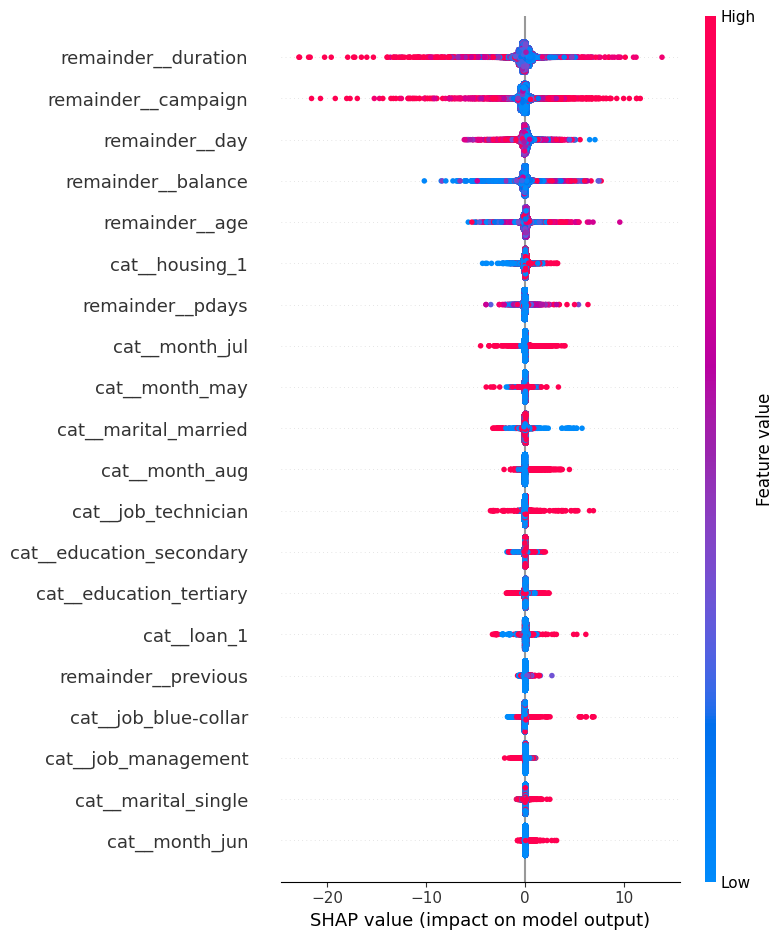

In [53]:
# convert dict_keys object to a list to make it subscriptable
output_name = list(shap_values.keys())[0] 
treatment_name = list(shap_values[output_name].keys())[0] 

specific_shap_values = shap_values[output_name][treatment_name]

feature_names = preprocessor.get_feature_names_out()

# visualize the SHAP values
shap.summary_plot(specific_shap_values, X, feature_names=feature_names)
